In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('DS_Sber.csv', sep=';')
data.columns = data.columns.str.lower()
data['reportdate'] = data['reportdate'].str.replace('.', '/')
data["reportdate"] = pd.to_datetime(data["reportdate"], infer_datetime_format=True)

data.head(10)

C:\Temp\ipykernel_4692\4256145899.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['reportdate'] = data['reportdate'].str.replace('.', '/')


,reportdate,value
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149
5,2014-01-04,3417092149
6,2014-01-05,3417092149
7,2014-01-06,3320846785
8,2014-01-07,3320846785
9,2014-01-08,3630283744


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   reportdate  2111 non-null   datetime64[ns]
 1   value       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


In [4]:
data.describe()

,value
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


<AxesSubplot: >

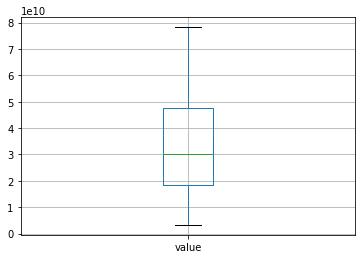

In [5]:
data.boxplot(['value'])

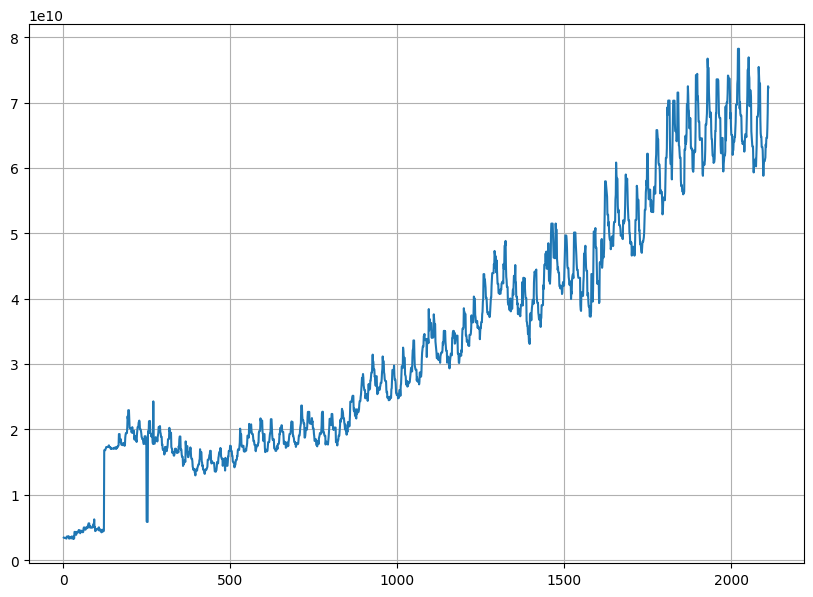

In [133]:
plt.figure(figsize=(10, 7))

plt.grid(True)
plt.plot(np.array([int(i) for i in range(1, len(data)+1)]), data.value)

plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [148]:
df = np.array(data.value.values)[252:]

df_train = np.array(df[:int(len(data) * 0.8)])
df_test = np.array(df[int(len(data) * 0.8):])

In [149]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scale = scaler.fit_transform(df_train.reshape(-1, 1))
test_scale = scaler.transform(df_test.reshape(-1, 1))

In [150]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [152]:
window = 120

train_gen = TimeseriesGenerator(train_scale, train_scale, length=window)
test_gen = TimeseriesGenerator(test_scale, test_scale, length=window)

In [153]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [166]:
model = Sequential(name='Sber')
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(window, 1)))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "Sber"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 120, 128)          66560     
                                                                 
 dropout_28 (Dropout)        (None, 120, 128)          0         
                                                                 
 lstm_38 (LSTM)              (None, 120, 128)          131584    
                                                                 
 dropout_29 (Dropout)        (None, 120, 128)          0         
                                                                 
 lstm_39 (LSTM)              (None, 64)                49408     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 247,617
Trainable params: 247,617
Non-trainable 

In [167]:
model.fit(train_gen, epochs=50, validation_data=test_gen)

Epoch 1/50
13/13 [==============================] - 12s 774ms/step - loss: 0.0834 - val_loss: 0.1180
Epoch 2/50
13/13 [==============================] - 11s 850ms/step - loss: 0.0765 - val_loss: 0.1164
Epoch 3/50
13/13 [==============================] - 10s 743ms/step - loss: 0.0461 - val_loss: 0.1146
Epoch 4/50
13/13 [==============================] - 10s 793ms/step - loss: 0.0339 - val_loss: 0.1070
Epoch 5/50
13/13 [==============================] - 10s 793ms/step - loss: 0.0333 - val_loss: 0.0955
Epoch 6/50
13/13 [==============================] - 10s 767ms/step - loss: 0.0340 - val_loss: 0.0833
Epoch 7/50
13/13 [==============================] - 10s 767ms/step - loss: 0.0168 - val_loss: 0.0399
Epoch 8/50
13/13 [==============================] - 10s 745ms/step - loss: 0.0143 - val_loss: 0.0074
Epoch 9/50
13/13 [==============================] - 10s 833ms/step - loss: 0.0173 - val_loss: 0.0646
Epoch 10/50
13/13 [==============================] - 12s 908ms/step - loss: 0.0124 - val_lo

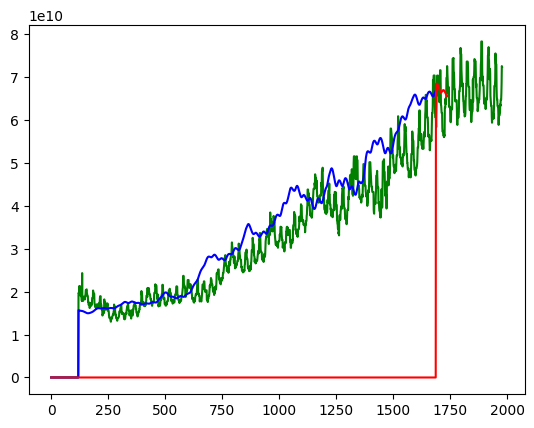

In [175]:
train_predict = scaler.inverse_transform(model.predict(train_gen))
test_predict = scaler.inverse_transform(model.predict(test_gen))
plt.plot(np.append(np.array([0] * window), df), color='g')
plt.plot(np.append(np.array([0]*window), train_predict), color='b')
plt.plot(np.append(np.array([0] * window), np.append(train_predict * 0, test_predict)), color='r')

# plt.plot(nswr*0.95, color='yellow')

In [168]:
nswr = df.copy().reshape(-1, 1)

for _ in range(window):
    test = scaler.transform(nswr.copy()[-window:].reshape(-1, 1))

    test = test.reshape(1, window, 1)

    test = scaler.inverse_transform(model.predict(test))
    
    nswr = np.append(nswr, test)
    
nswr = nswr.reshape(-1, 1)

In [169]:
nswr[-window:]

array([[6.55275172e+10],
       [6.55511347e+10],
       [6.55813878e+10],
       [6.56145859e+10],
       [6.56486728e+10],
       [6.56825590e+10],
       [6.57156874e+10],
       [6.57477714e+10],
       [6.57786675e+10],
       [6.58084168e+10],
       [6.58371092e+10],
       [6.58648596e+10],
       [6.58917827e+10],
       [6.59179766e+10],
       [6.59435028e+10],
       [6.59684106e+10],
       [6.59927409e+10],
       [6.60165550e+10],
       [6.60398940e+10],
       [6.60627579e+10],
       [6.60851835e+10],
       [6.61071790e+10],
       [6.61287690e+10],
       [6.61499331e+10],
       [6.61707366e+10],
       [6.61911921e+10],
       [6.62112993e+10],
       [6.62310502e+10],
       [6.62504776e+10],
       [6.62695526e+10],
       [6.62883287e+10],
       [6.63068303e+10],
       [6.63250698e+10],
       [6.63431086e+10],
       [6.63609221e+10],
       [6.63784571e+10],
       [6.63957709e+10],
       [6.64128430e+10],
       [6.64296817e+10],
       [6.64462868e+10],
